In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat
import xgcm

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

/home/yuxlong5/miniconda3/envs/equinox/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33969 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33969/status,
Dashboard: http://127.0.0.1:33969/status,Workers: 16
Total threads: 128,Total memory: 251.08 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46025,Workers: 16
Dashboard: http://127.0.0.1:33969/status,Total threads: 128
Started: Just now,Total memory: 251.08 GiB
Comm: tcp://127.0.0.1:34833,Total threads: 8
Dashboard: http://127.0.0.1:43029/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:34625,


______________
# Read data

In [3]:
out_dir_zarr = '/meddy/yuxlong5/data/SCS_LLC4320/'

ds = xr.open_zarr(out_dir_zarr+'llc_total_rechunk.zarr')
ds

<xarray.Dataset>
Dimensions:  (time: 8585, j: 1501, i: 1501, i_g: 1501, j_g: 1501)
Coordinates:
    XG       (j_g, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
  * i        (i) float32 97.43 97.45 97.47 97.49 ... 128.6 128.6 128.7 128.7
  * i_g      (i_g) float32 97.42 97.44 97.46 97.48 ... 128.6 128.6 128.6 128.7
  * j        (j) float32 1.558 1.577 1.596 1.616 ... 28.98 29.0 29.01 29.03
  * j_g      (j_g) float32 1.548 1.567 1.587 1.606 ... 28.97 28.99 29.0 29.02
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-11-15
Data variables:
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    KPPhbl   (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SST      (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SSU      (time, j, i_g) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SSV      (time, j_g, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    oceTAUX  (time, j, i_g) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    oceTAUY  (time, j_g, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>

In [9]:
lon = np.array(ds.XC.isel(j=1), dtype='>f')
ds_U = ds.SSU
ds_U = ds_U.assign_coords(i_g=lon) 
ds_U = ds_U.rename({'i_g': 'i'})
ds_U

<xarray.DataArray 'SSU' (time: 8585, j: 1501, i: 1501)>
dask.array<open_dataset-e4a176b9020ce481a26989b9c9d7e9dfSSU, shape=(8585, 1501, 1501), dtype=float32, chunksize=(1, 1501, 1501), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) >f4 97.43 97.45 97.47 97.49 97.51 ... 128.6 128.6 128.7 128.7
  * j        (j) float32 1.558 1.577 1.596 1.616 ... 28.98 29.0 29.01 29.03
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-11-15
Attributes:
    coordinates:    dxC dyG niter rAw
    long_name:      User-Defined U.vector Surface Diag.  #9
    mate:           SSV
    standard_name:  SDIAG9
    units:          user-defined

In [12]:
lat = np.array(ds.YC.isel(i=1), dtype='>f')
ds_V = ds.SSV
ds_V = ds_V.assign_coords(j_g=lat) 
ds_V = ds_V.rename({'j_g': 'j'})
ds_V

<xarray.DataArray 'SSV' (time: 8585, j: 1501, i: 1501)>
dask.array<open_dataset-e4a176b9020ce481a26989b9c9d7e9dfSSV, shape=(8585, 1501, 1501), dtype=float32, chunksize=(1, 1501, 1501), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) float32 97.43 97.45 97.47 97.49 ... 128.6 128.6 128.7 128.7
  * j        (j) >f4 1.558 1.577 1.596 1.616 1.635 ... 28.98 29.0 29.01 29.03
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-11-15
Attributes:
    coordinates:    dxG dyC niter rAs
    long_name:      User-Defined V.vector Surface Diag. #10
    mate:           SSU
    standard_name:  SDIAG10
    units:          user-defined

In [13]:
ds_UV = xr.merge([ds_U,ds_V])
ds_UV

<xarray.Dataset>
Dimensions:  (i: 1501, j: 1501, time: 8585)
Coordinates:
  * i        (i) >f4 97.43 97.45 97.47 97.49 97.51 ... 128.6 128.6 128.7 128.7
  * j        (j) float32 1.558 1.577 1.596 1.616 ... 28.98 29.0 29.01 29.03
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-11-15
Data variables:
    SSU      (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SSV      (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
Attributes:
    coordinates:    dxC dyG niter rAw
    long_name:      User-Defined U.vector Surface Diag.  #9
    mate:           SSV
    standard_name:  SDIAG9
    units:          user-defined

In [14]:
um = ds_UV.SSU.mean('time')
vm = ds_UV.SSV.mean('time')

In [15]:
MKE = (um**2 + vm**2)/2
MKE

<xarray.DataArray (j: 1501, i: 1501)>
dask.array<truediv, shape=(1501, 1501), dtype=float32, chunksize=(1501, 1501), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) >f4 97.43 97.45 97.47 97.49 97.51 ... 128.6 128.6 128.7 128.7
  * j        (j) float32 1.558 1.577 1.596 1.616 ... 28.98 29.0 29.01 29.03

In [27]:
EKE = (((ds_UV.SSU - um)**2 + (ds_UV.SSV - vm)**2)/2).mean('time')
EKE

<xarray.DataArray (j: 1501, i: 1501)>
dask.array<mean_agg-aggregate, shape=(1501, 1501), dtype=float32, chunksize=(1501, 1501), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) >f4 97.43 97.45 97.47 97.49 97.51 ... 128.6 128.6 128.7 128.7
  * j        (j) float32 1.558 1.577 1.596 1.616 ... 28.98 29.0 29.01 29.03

In [33]:
KE = ((ds_UV.SSU**2 + ds_UV.SSV**2)/2).mean('time')
KE

<xarray.DataArray (j: 1501, i: 1501)>
dask.array<mean_agg-aggregate, shape=(1501, 1501), dtype=float32, chunksize=(1501, 1501), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) >f4 97.43 97.45 97.47 97.49 97.51 ... 128.6 128.6 128.7 128.7
  * j        (j) float32 1.558 1.577 1.596 1.616 ... 28.98 29.0 29.01 29.03

In [34]:
KE.load()

<xarray.DataArray (j: 1501, i: 1501)>
array([[0.04698917, 0.0475497 , 0.04930918, ...,        nan,        nan,
               nan],
       [0.04769242, 0.04795103, 0.04918297, ...,        nan,        nan,
               nan],
       [0.04739342, 0.04747498, 0.04747099, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.08667955, 0.0872061 ,
        0.08842447],
       [       nan,        nan,        nan, ..., 0.08757243, 0.08804089,
        0.08904012],
       [       nan,        nan,        nan, ..., 0.08785115, 0.08843064,
        0.08935032]], dtype=float32)
Coordinates:
  * i        (i) >f4 97.43 97.45 97.47 97.49 97.51 ... 128.6 128.6 128.7 128.7
  * j        (j) float32 1.558 1.577 1.596 1.616 ... 28.98 29.0 29.01 29.03

In [28]:
EKE.load()

<xarray.DataArray (j: 1501, i: 1501)>
array([[0.04271823, 0.04321956, 0.0453326 , ...,        nan,        nan,
               nan],
       [0.04447541, 0.0449    , 0.04644707, ...,        nan,        nan,
               nan],
       [0.04470221, 0.0448755 , 0.04511131, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.07840024, 0.07960903,
        0.0814043 ],
       [       nan,        nan,        nan, ..., 0.07835983, 0.07962008,
        0.08124416],
       [       nan,        nan,        nan, ..., 0.07750906, 0.07906311,
        0.08069337]], dtype=float32)
Coordinates:
  * i        (i) >f4 97.43 97.45 97.47 97.49 97.51 ... 128.6 128.6 128.7 128.7
  * j        (j) float32 1.558 1.577 1.596 1.616 ... 28.98 29.0 29.01 29.03

In [16]:
MKE.load()

<xarray.DataArray (j: 1501, i: 1501)>
array([[0.00427094, 0.00433015, 0.00397657, ...,        nan,        nan,
               nan],
       [0.00321702, 0.00305103, 0.0027359 , ...,        nan,        nan,
               nan],
       [0.0026912 , 0.00259948, 0.00235968, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.00827931, 0.00759706,
        0.00702018],
       [       nan,        nan,        nan, ..., 0.0092126 , 0.00842082,
        0.00779594],
       [       nan,        nan,        nan, ..., 0.01034209, 0.00936753,
        0.00865694]], dtype=float32)
Coordinates:
  * i        (i) >f4 97.43 97.45 97.47 97.49 97.51 ... 128.6 128.6 128.7 128.7
  * j        (j) float32 1.558 1.577 1.596 1.616 ... 28.98 29.0 29.01 29.03

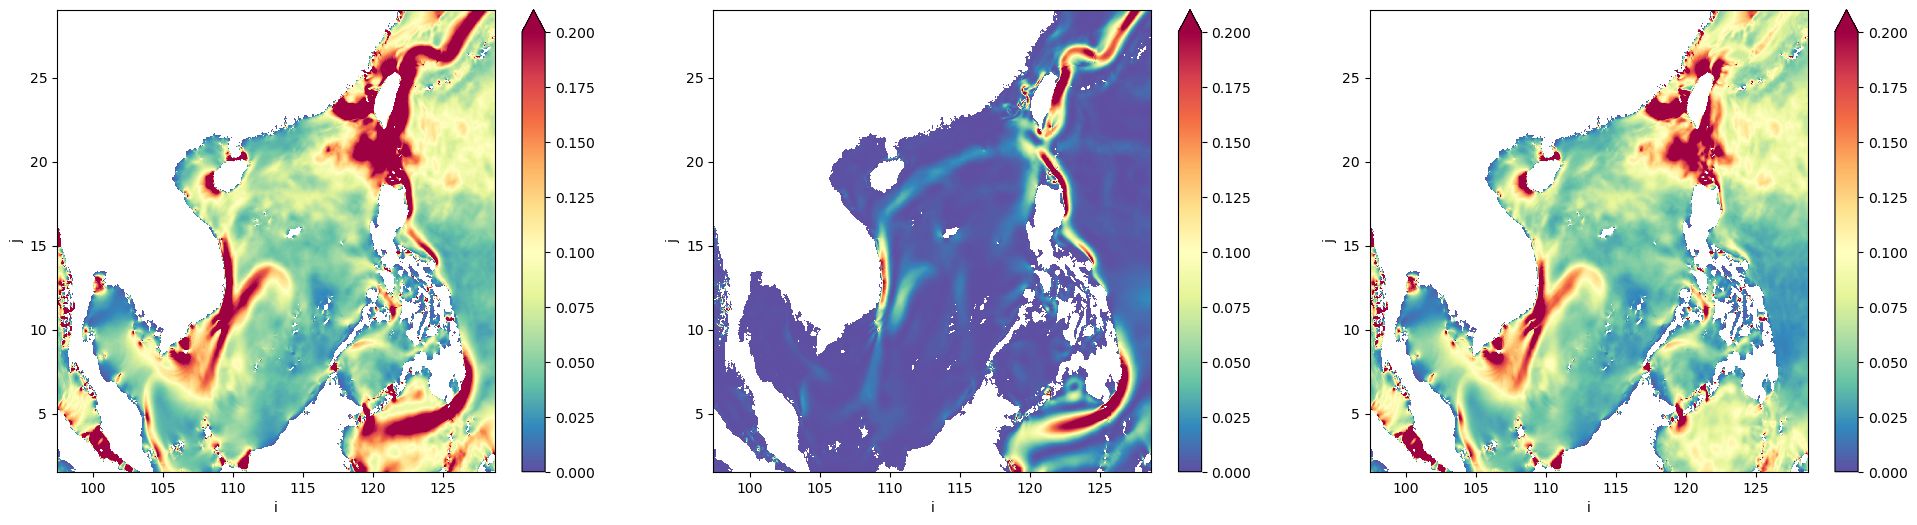

In [36]:
fig = plt.figure(figsize=(24,6))

plt.subplot(131)
KE.plot(vmax=0.2,vmin=0, cmap='Spectral_r')

plt.subplot(132)
MKE.plot(vmax=0.2,vmin=0, cmap='Spectral_r')

plt.subplot(133)
EKE.plot(vmax=0.2,vmin=0, cmap='Spectral_r')

In [40]:
speed = (np.sqrt(ds_UV.SSU**2 + ds_UV.SSV**2)).mean('time')
speed.load()

<xarray.DataArray (j: 1501, i: 1501)>
array([[0.24874145, 0.25159076, 0.2597204 , ...,        nan,        nan,
               nan],
       [0.25311592, 0.25492203, 0.26106563, ...,        nan,        nan,
               nan],
       [0.25659415, 0.257034  , 0.25828236, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.35666788, 0.35726792,
        0.3601508 ],
       [       nan,        nan,        nan, ..., 0.3583923 , 0.35856757,
        0.3606919 ],
       [       nan,        nan,        nan, ..., 0.35927993, 0.35955456,
        0.3605752 ]], dtype=float32)
Coordinates:
  * i        (i) >f4 97.43 97.45 97.47 97.49 97.51 ... 128.6 128.6 128.7 128.7
  * j        (j) float32 1.558 1.577 1.596 1.616 ... 28.98 29.0 29.01 29.03

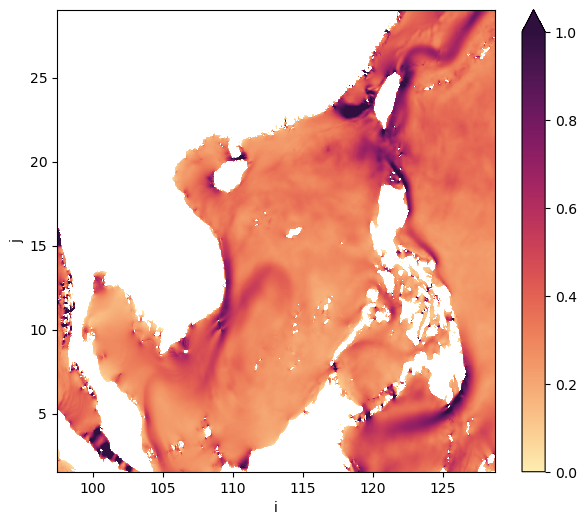

In [41]:
fig = plt.figure(figsize=(24,6))

plt.subplot(131)
speed.plot(vmax=1,vmin=0, cmap=cm.matter)


In [42]:
cluster.close()